<a href="https://colab.research.google.com/github/GreyGalileo/greygalileo/blob/main/NSIproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3, 1)


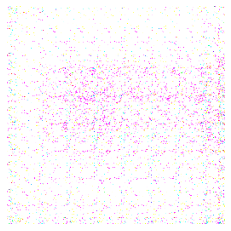

Time for epoch 55 is 407.7612645626068 sec


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import urllib
from urllib import request
from PIL import Image

#generator creates 16*16*3 tensor (~16*16 RBG image) from on random noise
def make_generator(): return tf.keras.Sequential(
    [
     layers.Dense(8*8*3*128, use_bias=False, input_shape=(100,)),
     layers.BatchNormalization(),
     layers.LeakyReLU(),
     layers.Reshape((8,8,3,128)),
     #shape = 8, 8, 3, 128

     layers.Conv3DTranspose(64,(5,5,3),strides=(1,1,1), use_bias=False,padding="same"),
     layers.LeakyReLU(),
     #shape = 8, 8, 3, 64

     layers.Conv3DTranspose(32,(5,5,3),strides=(2,2,1), use_bias=False,padding="same"),
     layers.LeakyReLU(),
     #shape = 16, 16, 3, 32

     layers.Conv3DTranspose(16,(5,5,3),strides=(2,2,1), use_bias=False, padding="same"),
     layers.LeakyReLU(),
     #shape = 32, 32, 3, 16

     layers.Conv3DTranspose(8,(2,2,1),strides=(2,2,1), use_bias=False),
     layers.LeakyReLU(),
     #shape = 64, 64, 3, 8

     layers.Conv3DTranspose(4,(2,2,1),strides=(2,2,1), use_bias=False),
     #shape = 128, 128, 3, 4

     layers.Conv3DTranspose(1,(2,2,1),strides=(2,2,1), use_bias=False),
     #shape = 256, 256, 3, 1

     layers.Lambda(function = lambda x : abs(x))
    ]
)

#discriminator takes an image in the format created by the geneartor and evaluates whether or not it is real or generated
def make_discriminator(): return keras.Sequential(
    [
     layers.Conv3D(32,(5,5,1),strides=(2,2,1),padding = "same",input_shape=(256,256,3,1)),
     layers.LeakyReLU(),
     layers.Dropout(0.3),

     layers.Conv3D(64,(5,5,1),strides=(2,2,1),padding = "same"),
     layers.LeakyReLU(),
     layers.Dropout(0.3),

     layers.Conv3D(128,(2,2,3),strides=(1,1,1),padding = "same"),
     layers.LeakyReLU(),

     layers.Conv3D(265,(2,2,1),strides=(1,1,1)),

     layers.Flatten(),
     layers.Dense(1)
    ]
)

#calculates loss for generator and discriminator based on how well they generate images and determine image generation respectively
cross_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def checkpoint_path():
  global checkpoint_prefix
  checkpoint_prefix = os.path.join('./training_checkpoints', "ckpt")
  global checkpoint
  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)



#loads artwork from premade csv "smithsonian_abstract_expressionism" for training discriminator
def load_artwork():
  train_images = np.zeros([1,256,256,3])
  with open("airspace_museum") as image_links:
    image_links = csv.reader(image_links)
    for link in image_links:
      try:
        with request.urlopen(link[0]) as image:
          with Image.open(image) as image:
            image = np.array(image)
            h,w,_ = np.shape(image)
            for dim in (h,w) : assert dim >= 256
            image = np.array([image[h//2-(128):h//2-(128)+256,w//2-(128):w//2-(128)+256,:]])
            train_images = np.append(train_images,image,0)
      except (ValueError, urllib.error.HTTPError, AssertionError):
        print(link[0])

  #transform data from integers between 0 and 256 to floats between 0 and 1 so it can be used by the discriminator
  train_images = train_images[1:,:,:,:]/256
  #changes datatype of images to float32, to be interpreted by the discriminator
  train_images = train_images.reshape(train_images.shape[0], 256, 256, 3).astype('float32')
  # Batch and shuffle the data
  train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  return train_dataset

BUFFER_SIZE = 600
BATCH_SIZE = 80



EPOCHS = 120
seed = tf.random.normal([1, 100])

@tf.function
def train_step(images):

    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

import time
from IPython import display # A command shell for interactive computing in Python.

def generate_and_save_images(model, epoch, test_input):
  # This is so all layers run in inference mode (batchnorm).
  #Generate image
  predictions = model(test_input, training=False)
  #Plot the generated image
  print(predictions.shape)
  plt.imshow(predictions[0, :, :, :, 0]*256)
  plt.axis('off')
  #Save the generated image
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

def train(dataset, epochs):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch, 
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 5 epochs as a checkpoint
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

if __name__ == "__main__":
  generator = make_generator()
  discriminator = make_discriminator()
  checkpoint_path()
  train_dataset = load_artwork()
  train(train_dataset, EPOCHS)


In [ ]:
import os
import csv
from urllib import request
from bs4 import BeautifulSoup as BS

with open("smithsonian_abstract_expressionism", 'w') as result:
  writer = csv.writer(result,delimiter=' ')
  for i in range(3):
    with request.urlopen('https://www.si.edu/search/collection-images?page={}&edan_fq%5B0%5D=set_name%3A%22Abstract%20Expressionism%20%28First%20Generation%29%22&edan_fq%5B1%5D=object_type%3A%22Paintings%22'.format(i))  as source:
      soup = BS(source)
      for imgtag in soup.find_all('img'):
        if imgtag['src'].startswith("https://ids.si.edu/ids/deliveryService?max_w=550&id="):
          writer.writerow([imgtag['src']])

In [1]:
import os
import csv
from urllib import request
from bs4 import BeautifulSoup as BS

with open("airspace_museum", 'w') as result:
  writer = csv.writer(result,delimiter=' ')
  for i in range(6):
    with request.urlopen('https://www.si.edu/search/collection-images?page={}&edan_fq%5B0%5D=set_name%3A%22National%20Air%20and%20Space%20Museum%20Collection%22&edan_fq%5B1%5D=%28object_type%3A%22Works%20of%20art%22%20AND%20object_type%3A%22Paintings%22%29'.format(i))  as source:
      soup = BS(source)
      for imgtag in soup.find_all('img'):
        if imgtag['src'].startswith("https://ids.si.edu/ids/deliveryService?max_w=550&id="):
          writer.writerow([imgtag['src']])